# Učitavanje podataka

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")

train_df.shape
train_df.head()

# Osnovna analiza i informacije

In [ ]:
train_df.info()
train_df.describe()

# Provjera nedostajućih vrijednosti

In [ ]:
missing = train_df.isnull().sum().sort_values(ascending=False)
missing[missing > 0]

# Provjera outliera

In [ ]:
plt.scatter(train_df["GrLivArea"], train_df["SalePrice"])
plt.title("GrLivArea vs SalePrice")

# Analiza numeričkih i kategorijskih varijabli

In [ ]:
numeric_cols = train_df.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = train_df.select_dtypes(include=["object"]).columns

print("Broj numeričkih:", len(numeric_cols))
print("Broj kategorijskih:", len(categorical_cols))

train_df[categorical_cols].nunique().sort_values()

# Korelacija s ciljnim atributom (SalePrice)

In [ ]:
correlation = train_df[numeric_cols].corr()["SalePrice"].sort_values(ascending=False)
correlation.head(15)

# Vizualna korelacija (heatmap)
plt.figure(figsize=(12,10))
sns.heatmap(train_df[numeric_cols].corr(), cmap="coolwarm", annot=False)

correlation = train_df.corr(numeric_only=True)["SalePrice"].sort_values(ascending=False)
print(correlation.head(15))


# Analiza ciljne varijable SalePrice

In [ ]:
sns.histplot(train_df["SalePrice"], kde=True)
plt.title("Distribucija SalePrice")

# Unique vrijednosti za kategorijske kolone

In [ ]:
train_df[categorical_cols].nunique().sort_values()

# Statistički rezime SalePrice i ključnih varijabli

In [ ]:
train_df["SalePrice"].describe()
train_df[["OverallQual", "GrLivArea", "GarageCars", "TotalBsmtSF"]].describe()

train_df[numeric_cols].skew().sort_values(ascending=False).head(10)

# Analiza najjače koreliranih feature-a sa SalePrice

In [ ]:
top_corr = correlation[1:6].index
for col in top_corr:
    sns.scatterplot(x=train_df[col], y=train_df["SalePrice"])
    plt.title(f"{col} vs SalePrice")
    plt.show()

# Višedimenzionalna analiza ključnih feature-a

In [ ]:
sns.lmplot(data=train_df, x="GrLivArea", y="SalePrice", hue="OverallQual", fit_reg=False, height=6)

# Boxplot za SalePrice vs Kategorijske varijable

In [ ]:
plt.figure(figsize=(15,8))
sns.boxplot(x="Neighborhood", y="SalePrice", data=train_df)
plt.xticks(rotation=45)
plt.title("Cijena po naselju")

# Provjera duplikata

In [ ]:
train_df.duplicated().sum()

# Provjera kolona sa niskim varijacijama (low variance)

In [ ]:
low_variance = [col for col in train_df.columns if train_df[col].nunique() < 3]
print("Kolone sa skoro istim vrijednostima:", low_variance)

# Vizualna analiza odnosa varijabli (pairplot)

In [ ]:
sns.pairplot(train_df[["SalePrice", "GrLivArea", "TotalBsmtSF", "1stFlrSF", "GarageArea"]])

# Kolone sa NaN vrijednostima

In [ ]:
col_nan = train_df.isna().sum() / train_df.shape[0]

plt.figure(figsize=(8, 5))
sns.set(font_scale=1.2)
col_nan[col_nan > 0.01].plot(kind = "barh")
plt.title("Kolone sa najvećim postotkom NaN vrijednosti")

# Čišćenje podataka

# Uklanjanje ID kolona

In [ ]:
train_df = train_df.drop("Id", axis=1)
test_df = test_df.drop("Id", axis=1)

# Uklanjanje kolona sa istim vrijednostima

In [ ]:
train_df = train_df.drop(["Street", "Utilities"], axis=1)
test_df = test_df.drop(["Street", "Utilities"], axis=1)

# Uklanjanje outliera

In [ ]:
train_df = train_df.drop(train_df[(train_df['GrLivArea'] > 4500)].index)

# Spajanje train + test u jedan skup radi zajedničke obrade

In [ ]:
y = train_df['SalePrice']
train_features = train_df.drop(['SalePrice'], axis=1)
all_data = pd.concat([train_features, test_df]).reset_index(drop=True)

# Ispravljanje grešaka u podacima

In [ ]:
all_data.loc[all_data['GarageYrBlt'] > 2017, 'GarageYrBlt'] = 2007

# Popunjavanje LotFrontage po Neighborhood

In [ ]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Numeričke koje treba pretvoriti u kategorijske

In [ ]:
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

# Z-score metoda za uklanjanje outliera (samo na train_df)

In [ ]:
from scipy import stats
import numpy as np

def remove_outliers(dataset, threshold=3, columns=None):
    if columns is None:
        columns = dataset.select_dtypes(include=['int64', 'float64']).columns
    z = np.abs(stats.zscore(dataset[columns]))
    outliers = (z > threshold).any(axis=1)
    print(f"Uklonjeno redova: {outliers.sum()}")
    return dataset[~outliers]

# Primijeni samo na trening skup jer je target poznat
train_df_clean = remove_outliers(train_df, columns=['GrLivArea'])

# Popunjavanje nedostajućih vrijednosti (numeričke)

In [ ]:
from sklearn.impute import SimpleImputer

zero_fill = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']
median_fill = [col for col in all_data.select_dtypes(include=['int64', 'float64']).columns if col not in zero_fill]

all_data[zero_fill] = all_data[zero_fill].fillna(0)
all_data[median_fill] = all_data[median_fill].fillna(all_data[median_fill].median())

# Popunjavanje kategorijskih kolona specifičnim vrijednostima

In [ ]:
none_conversion = [
    ("MasVnrType","None"), ("BsmtQual","NA"), ("Electrical", "SBrkr"),
    ("BsmtCond","TA"), ("BsmtExposure","No"), ("BsmtFinType1","No"), ("BsmtFinType2","No"),
    ("FireplaceQu","NA"), ("GarageType","No"), ("GarageFinish","No"),
    ("GarageQual","NA"), ("GarageCond","NA"), ("KitchenQual","TA"),
    ("Functional","Typ"), ("MSZoning", "None"), ("Exterior1st", "VinylSd"),
    ("Exterior2nd", "VinylSd"), ("SaleType", "WD")
]

for col, val in none_conversion:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna(val)

# Transformacija "skewed" kolona sa Box-Cox

In [ ]:
from scipy.special import boxcox1p
from scipy.stats import skew

numeric_feats = all_data.select_dtypes(include=['int64', 'float64']).columns
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
high_skew = skewed_feats[skewed_feats > 0.5].index

for feat in high_skew:
    all_data[feat] = boxcox1p(all_data[feat], 0.15)

# Enkodiranje kategorijskih varijabli za xGBoost i Random Forest

In [ ]:
from sklearn.preprocessing import LabelEncoder

def encode_features(df):
    df = df.copy()
    label_encoders = {}

    # 1. Ručno mapiranje ordinalnih varijabli
    ordinal_mappings = {
        "ExterQual": {"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
        "ExterCond": {"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
        "BsmtQual": {"NA":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
        "BsmtCond": {"NA":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
        "HeatingQC": {"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
        "KitchenQual": {"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
        "FireplaceQu": {"NA":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
        "GarageQual": {"NA":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
        "GarageCond": {"NA":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
        "PoolQC": {"NA":0, "Fa":1, "TA":2, "Gd":3, "Ex":4},
        "BsmtExposure": {"NA":0, "No":1, "Mn":2, "Av":3, "Gd":4},
        "BsmtFinType1": {"NA":0, "Unf":1, "LwQ":2, "Rec":3, "BLQ":4, "ALQ":5, "GLQ":6},
        "BsmtFinType2": {"NA":0, "Unf":1, "LwQ":2, "Rec":3, "BLQ":4, "ALQ":5, "GLQ":6},
        "Functional": {"Sal":1, "Sev":2, "Maj2":3, "Maj1":4, "Mod":5, "Min2":6, "Min1":7, "Typ":8},
        "GarageFinish": {"NA":0, "Unf":1, "RFn":2, "Fin":3},
        "Fence": {"NA":0, "MnWw":1, "GdWo":2, "MnPrv":3, "GdPrv":4},
        "LotShape": {"IR3":1, "IR2":2, "IR1":3, "Reg":4},
        "PavedDrive": {"N":0, "P":1, "Y":2},
        "Utilities": {"ELO":1, "NoSeWa":2, "NoSewr":3, "AllPub":4},
        "LandSlope": {"Sev":1, "Mod":2, "Gtl":3}
    }

    for col, mapping in ordinal_mappings.items():
        if col in df.columns:
            df[col] = df[col].map(mapping).fillna(0).astype(int)

    # 2. Label Encoding za ostale kategorijske varijable (koje su object dtype)
    categorical_cols = df.select_dtypes(include=['object']).columns

    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = df[col].astype(str)  # sigurnost ako ima NaN
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le  # čuvamo enkodere za kasnije (npr. test skup)

    return df, label_encoders

In [35]:
all_data_encoded, label_encoders = encode_features(all_data)

In [ ]:
X_train = all_data_encoded.iloc[:train_features.shape[0], :].copy()
X_test = all_data_encoded.iloc[train_features.shape[0]:, :].copy()

# Provjera čišćenja

In [38]:
print("X_train shape:", X_train.shape)
print("y shape:", y.shape)
print("X_test shape:", X_test.shape)

X_train shape: (1458, 77)
y shape: (1458,)
X_test shape: (1459, 77)


# Provjera NaN vrijednosti

In [39]:
print("NaN u X_train:", X_train.isnull().sum().sum())
print("NaN u X_test:", X_test.isnull().sum().sum())

NaN u X_train: 0
NaN u X_test: 0


# Provjera tipova podataka

In [40]:
print(X_train.dtypes.value_counts())

int64      50
float64    27
Name: count, dtype: int64


# Provjera distribucije target varijable (y)

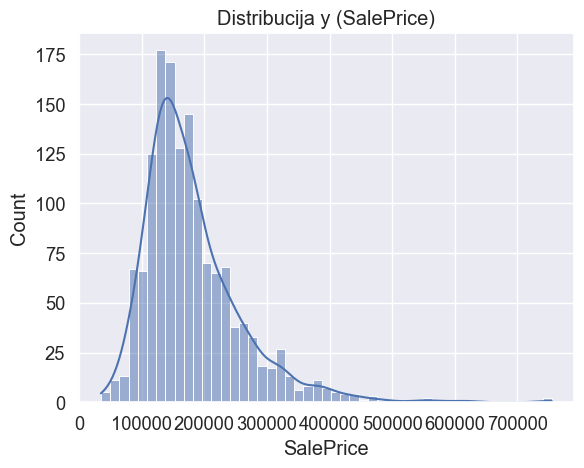

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(y, kde=True)
plt.title("Distribucija y (SalePrice)")
plt.show()

# Provjera korelacija

In [42]:
train_corr = X_train.copy()
train_corr["SalePrice"] = y
correlation = train_corr.corr()["SalePrice"].sort_values(ascending=False)
print(correlation.head(10))

SalePrice      1.000000
OverallQual    0.287047
GrLivArea      0.248560
GarageCars     0.244847
GarageArea     0.243663
ExterQual      0.242166
KitchenQual    0.230058
BsmtQual       0.227074
1stFlrSF       0.218437
FireplaceQu    0.213916
Name: SalePrice, dtype: float64
